Hi everyone.

In this issue, I would like to share an improvement that I made on the function of Pyriemann : _sample_parameter_r.

The improvement only relates to the two dimension case (n_dim=2) but in this case, it is a lot faster than the previous version.

The idea is to use the rejection sampling instead of the slice sampling.
To have a first look, here is a graph of the speedup for the two dimension case depending on the number of samples for $\sigma$  = 1 .

![alt text](comparaison.png "Compare the speedup of slice and rejection sampling")

First, have a look on the rejection sampling theory to sample parameter r.

We want to sample the vector of $r = (r_1, \dots, r_m)$ from the probability distribution

$$
p(r) = \dfrac{1}{Z(m, \sigma)} \exp\left(-\frac{1}{2\sigma^2}\sum_{i = 1}^m r^2_i\right) \times \prod_{i < j}\sinh\left(|r_i - r_j|/2\right)
$$

which has to be done via some computational method. At the moment, `pyriemann` uses a slice sampling approach [[1]](https://projecteuclid.org/journals/annals-of-statistics/volume-31/issue-3/Slice-sampling/10.1214/aos/1056562461.full) to obtain samples from $p(r)$ but this is rather slow. I suggest we change the implementation to a rejection sampling approach [[2]](https://en.wikipedia.org/wiki/Rejection_sampling), exploring some of the properties of $p$ and therefore obtaining better performance.

### The 2D case

We start our exploration with the simplest case, that of $m = 2$. The pdf for $r = (r_1, r_2)$ simplifies to:

$$
\begin{array}{rcl}
p(r_1, r_2) &=& \dfrac{1}{Z(2, \sigma)}\exp\left(-\dfrac{1}{2\sigma^2}(r_1^2 + r_2^2)\right) \times \sinh\left(|r_1 - r_2|/2\right) \\[1em]
&=& \dfrac{1}{Z(2, \sigma)}\exp\left(-\dfrac{1}{2\sigma^2}(r_1^2 + r_2^2)\right) \times \Big(\mathbf{1}_{\{r_1 - r_2 \geq 0\}}\sinh\left((r_1 - r_2)/2\right) + \mathbf{1}_{\{r_1 - r_2 < 0\}}\sinh\left((r_2 - r_1)/2\right) \Big)
\end{array}
$$

we can see this pdf as a mixture of two components depending on a binary variable $b$

$$
p(r) = p(r \mid b = 0) \times \mathbb{P}(b = 0) + p(r \mid b = 1) \times \mathbb{P}(b = 1)
$$

with $\mathbb{P}(b = 0) = \mathbb{P}(b = 1) = 1/2$ and

$$
p(r \mid b = 0) = \dfrac{2}{Z(2, \sigma)}\exp\left(-\dfrac{1}{2\sigma^2}(r_1^2 + r_2^2)\right) \times \mathbf{1}_{\{r_1 - r_2 \geq 0\}}\sinh\left((r_1 - r_2)/2\right)
$$
and
$$
p(r \mid b = 1) = \dfrac{2}{Z(2, \sigma)}\exp\left(-\dfrac{1}{2\sigma^2}(r_1^2 + r_2^2)\right) \times \mathbf{1}_{\{r_1 - r_2 < 0\}}\sinh\left((r_2 - r_1)/2\right)
$$

So we can see that to generate a sample from $p(r)$ we can first generate a Bernoulli variable $b \sim \mathcal{B}(1/2)$ and then sample from one of the conditional distributions. 

Let's see how we would sample from $p(r \mid b = 0)$ using rejection sampling. First, we would need to find a nice pdf that is an upper bound to it. Considering the inequality valid for all $x$ in $\mathbb{R}$: 
$$
\begin{array}{rcl}
sinh(x) \leq exp(x)
\end{array}
$$

we can write

$$
\begin{array}{rcl}
p(r \mid b = 0) &=& \dfrac{2}{Z(2, \sigma)}\exp\left(-\dfrac{1}{2\sigma^2}(r_1^2 + r_2^2)\right) \times \mathbf{1}_{\{r_1 - r_2 \geq 0\}}\sinh\left((r_1 - r_2)/2\right) \\[1em]

&\leq& \dfrac{1}{Z(2, \sigma)} \exp\left(-\dfrac{1}{2\sigma^2}(r_1^2 + r_2^2)\right) \times \mathbf{1}_{\{r_1 - r_2 \geq 0\}}\exp\big((r_1 - r_2)/2\big) \\[1em]
&\leq& \dfrac{2\pi\sigma^2 \exp(\sigma^2/4)}{Z(2, \sigma)} \times \dfrac{1}{2\pi \sigma^2}\exp\left(-\dfrac{1}{2\sigma^2}\Big(\big(r_1-\sigma^2/2\big)^2 + \big(r_2+\sigma^2/2\big)^2\Big)\right)
\end{array}
$$

The results above indicate that if we want to sample from $p(r \mid b = 0)$ we can do it via rejection sampling using as auxiliary distribution 

$$
g_0(r) = \dfrac{1}{2\pi \sigma^2}\exp\left(-\dfrac{1}{2\sigma^2}\Big(\big(r_1-\sigma^2/2\big)^2 + \big(r_2+\sigma^2/2\big)^2\Big)\right)
$$

the algorithm goes as follows:
1. Sample $u \sim \mathcal{U}(0, 1)$ and $r \sim g_0(r)$

2. Check whether 
$$
u < \mathbf{1}_{r_1 - r_2 \geq 0}~\exp\left(-\dfrac{1}{2\sigma^2}(r_1^2+r_2^2)\right)\sinh((r_1 - r_2)/2)\times\dfrac{1}{M g_0(r)}
$$

- If this holds, then accept $r$ as a sample from $p(r \mid b = 0)$
- If not, reject the sample

Where $M = \pi\sigma^2 \exp(\sigma^2/4)$

We implement naively this algorithm in the function `rejection_sampling` below.

In [16]:
#!/usr/bin/env python3

import numpy as np
from sklearn.utils import check_random_state
from scipy.stats import multivariate_normal
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from scipy.stats import norm

def rejection_sampling_A(sigma, r_sample):
    """ side function used for the rejection sampling 
    algorithm in the case where we generate r with 
    the first multivariate normal pdf
    Parameters
    ----------
    sigma : float
        Dispersion of the Riemannian Gaussianutograd.
        Sample of the r parameters of the Riemannian Gaussian distribution.
    Returns
    -------
    probability_of_acceptation : float
    """
    MU_A = np.array([sigma**2/2, -sigma**2/2])
    COV_MATRIX = (sigma**2)*np.eye(2)
    M = np.pi*(sigma**2)*np.exp(sigma**2/4)
    if r_sample[0] >= r_sample[1]:
        M = np.pi*(sigma**2)*np.exp(sigma**2/4)
        num = np.exp(-1/(2*sigma**2) * np.sum(r_sample**2)) * np.sinh((r_sample[0] - r_sample[1])/2) * 1/M
        den = multivariate_normal.pdf(r_sample, mean=MU_A, cov=COV_MATRIX)
        return num / den
    return 0

def rejection_sampling_B(sigma, r_sample):
    """ side function used for the rejection sampling 
    algorithm in the case where we generate r with 
    the second multivariate normal pdf
    Parameters
    ----------
    sigma : float
        Dispersion of the Riemannian Gaussian distribution.
    r_samples : ndarray, shape (n_samples, n_dim)
        Samples of the r parameters of the Riemannian Gaussian distribution.
    Returns
    -------
    probability_of_acceptation : float
    """
    MU_B = np.array([-sigma**2/2, sigma**2/2])
    COV_MATRIX = (sigma**2)*np.eye(2)
    M = np.pi*(sigma**2)*np.exp(sigma**2/4)
    if r_sample[0] < r_sample[1]:
        M = np.pi*(sigma**2)*np.exp(sigma**2/4)
        num = np.exp(-1/(2*sigma**2) * np.sum(r_sample**2)) * np.sinh((r_sample[1] - r_sample[0])/2)
        den = multivariate_normal.pdf(r_sample, mean=MU_B, cov=COV_MATRIX)*M
        return num/den
    return 0

def rejection_sampling_v1(n_samples, sigma):
    """ rejection sampling algorithm optimized for spatial 
    complexity but not for time complexity works very well 
    for low sigma values
    Parameters
    ----------
    n_samples : int
        Number of samples to get from the ptarget distribution.
    sigma : float
        Dispersion of the Riemannian Gaussian distribution.
    random_state : int, RandomState instance or None, default=None
        Pass an int for reproducible output across multiple function calls.
    Returns
    -------
    r_samples : ndarray, shape (n_samples, n_dim)
        Samples of the r parameters of the Riemannian Gaussian distribution.
    """
    MU_A = np.array([sigma**2/2, -sigma**2/2])
    MU_B = np.array([-sigma**2/2, sigma**2/2])
    COV_MATRIX = (sigma**2)*np.eye(2)
    M = np.pi*(sigma**2)*np.exp(sigma**2/4)
    RES = []
    cpt = 0
    while cpt != n_samples:
        if np.random.binomial(1, 0.5, 1) == 1:  # correction du pb du prgm précédent
            r_sample = multivariate_normal.rvs(MU_A, COV_MATRIX, 1) # correction du pb du prgm précédent
            res = rejection_sampling_A(sigma, r_sample) 
            if np.random.rand(1) < res:   # correction du pb du prgm précédent
                RES.append(r_sample)
                cpt += 1
        else:
            r_sample = multivariate_normal.rvs(MU_B, COV_MATRIX, 1)  # correction du pb du prgm précédent
            res = rejection_sampling_B(sigma, r_sample)
            if np.random.rand(1) < res:  # correction du pb du prgm précédent
                RES.append(r_sample)
                cpt+=1
    return np.array(RES)

This naive algorithm even works for very small $\sigma$ values (when $\sigma \le 0,1$ the slice sampling is so long that we can consider it as not functionnal). It has a very low spatial complexity and it is faster than the slice sampling algorithm but we can do better in terms of time complexity, especially for larger $\sigma$ values.

![alt text](rejec_slice_small_sigma.png "Compare the speedup of slice and rejection sampling")

We keep the side functions rejection_sampling_A and rejection_sampling_B but we change the way of doing the rejection_sampling function.
We stock samples from the multivariate_normal distribution, 

$$
g_0(r) = \dfrac{1}{2\pi \sigma^2}\exp\left(-\dfrac{1}{2\sigma^2}\Big(\big(r_1-\sigma^2/2\big)^2 + \big(r_2+\sigma^2/2\big)^2\Big)\right)
$$

$$
g_1(r) = \dfrac{1}{2\pi \sigma^2}\exp\left(-\dfrac{1}{2\sigma^2}\Big(\big(r_1+\sigma^2/2\big)^2 + \big(r_2-\sigma^2/2\big)^2\Big)\right)
$$

We also stock samples from the binomial distribution, $B(0.5, N)$ and we have the following algorithm (we will figure out then which value we have to affect to $N$):

In [1]:
# M1 = multivariate_normal.rvs(MU_A, COV_MATRIX, N, random_state=random_state)
# M2 = multivariate_normal.rvs(MU_B, COV_MATRIX, N, random_state=random_state)

# B = rs.binomial(1, 0.5, N)

In [39]:
def rejection_sampling_v2(n_samples, sigma, random_state=None):
    """ rejection sampling algorithm 
    optimized for time complexity but not for spatial complexity,
    works very well for any sigma values which is not too low (<0.01)
    Parameters
    ----------
    n_samples : int
        Number of samples to get from the ptarget distribution.
    sigma : float
        Dispersion of the Riemannian Gaussian distribution.
    random_state : int, RandomState instance or None, default=None
        Pass an int for reproducible output across multiple function calls.
    Returns
    -------
    r_samples : ndarray, shape (n_samples, n_dim)
        Samples of the r parameters of the Riemannian Gaussian distribution.
    """
    N = int(n_samples/rejection_acceptation_probability_shifted(sigma) + 1000) #on fait un +1000 pour contrer tou pb pour des valeurs faibles de sigma
    MU_A = np.array([sigma**2/2, -sigma**2/2])
    MU_B = np.array([-sigma**2/2, sigma**2/2])
    COV_MATRIX = (sigma**2)*np.eye(2)
    M = np.pi*(sigma**2)*np.exp(sigma**2/4)
    RES = []
    cpt = 0
    rs = np.random.Randomstate(random_state)
    B = rs.binomial(1, 0.5, N)
    M1 = multivariate_normal.rvs(MU_A, COV_MATRIX, N, random_state=random_state)
    M2 = multivariate_normal.rvs(MU_B, COV_MATRIX, N, random_state=random_state)
    R = rs.rand(N)
    icount_br = 0
    kcount_m1 = 0
    lcount_m2 = 0
    while cpt != n_samples:
        if B[icount_br] == 1:
            r_sample = M1[kcount_m1]
            kcount_m1+=1
            res = rejection_sampling_A(sigma, r_sample)
            if R[icount_br] < res:
                RES.append(r_sample)
                cpt += 1
            icount_br+=1
            if (icount_br>=N) and (cpt != n_samples):
                raise ValueError("sigma value too low")
        else:
            r_sample = M2[lcount_m2]
            lcount_m2+=1
            res = rejection_sampling_B(sigma, r_sample)
            if R[icount_br] < res:
                RES.append(r_sample)
                cpt+=1
            icount_br+=1
            if (icount_br>=N) and (cpt != n_samples):
                raise ValueError("sigma value too low")
    return np.array(RES)

rejection_sampling_v2(100, 1, 1)

AttributeError: module 'numpy.random' has no attribute 'Randomstate'

![alt text](3.png "Compare the speedup of slice and rejection sampling")

To have a better view, we can now just compare our two rejection sampling algorithms.

![alt text](2.png "Compare the speedup of slice and rejection sampling")

![alt text](2_2.png "Compare the speedup of slice and rejection sampling")

We have seen that the rejection_sampling_v2 is better for any number of r_sample and any $\sigma$ value greater than $0,05$, but it is not better for small $\sigma$ values and the reason is linked to the $N$ value we have to choose.


This $N$ value is the maximum number of r_sample we are able to generate with the rejection_sampling_v2 algorithm. 


To grasp the idea, we go back to the beginning of this paper. The first step of a rejection sampling algorithm is to sample $u \sim \mathcal{U}(0, 1)$ and $r \sim g_0(r)$. We showed (with the comparison between rejection_sampling v1 and v2) that a computer is a lot faster when the sampling of $u \sim \mathcal{U}(0, 1)$ and $r \sim g_0(r)$ is all made at the beginning of an algorithm. So, we have to know approximately the number of times we have to sample $u \sim \mathcal{U}(0, 1)$ and $r \sim g_0(r)$ to have enough r_samples at the end of the rejection sampling algorithm. This is $N$, and it has to be greater than the probability of acceptation of our algorithm multiplied by the number of r_samples the user want.

$N \geq \mathbb{P}(A)$ x n_samples

We can notice that $\mathbb{P}(A) = \dfrac{Z(m, \sigma)}{M(\sigma)}$


![alt text](ncM.png "Compare the speedup of slice and rejection sampling")

We approximate $\mathbb{P}(A)$ with a polynomial function of degree 3 named $f$, and we put a shift to assure that $N = \frac{n sample}{f(\sigma)} \geq \frac{n sample}{\mathbb{P}(A)}$

![alt text](f.png "Compare the speedup of slice and rejection sampling")

In [4]:
def rejection_acceptation_probability(t):
    """polynomial function which approaches the probability 
    of acceptation of the rejection_sampling algorithm depending on sigma
    Parameters
    ----------
    t : float
    Returns
    -------
    rejection_acceptation_probability(t) : float
    """
    return 0.01265*t**3 - 0.1648*t**2 + 0.7145*t-0.03374

def rejection_acceptation_probability_shifted(t):
    """polynomial function which approach the probability 
    of acceptation of the rejection_sampling algorithm depending on sigma, 
    the shift is used to estimate with confidence how many sample we need to get n_samples
    Parameters
    ----------
    t : float
    Returns
    -------
    rejection_acceptation_probability_shifted(t) : float
    """
    if t<=0.3:
        return 0.02
    else:
        return 0.01265*t**3 - 0.1648*t**2 + 0.7145*t-0.15

Despite this fact, when $\sigma \le 0,03$,  $\mathbb{P}(A)$ is very low, it is then impossible to choose $N$ bigger enough to assure the generation of all r_samples.

![alt text](error.png "Compare the speedup of slice and rejection sampling")

The rejection algorithm v1 does not have this problem, that is why we split the final rejection sampling algorithm into two cases:

In [15]:
def rejection_sampling(n_samples, sigma, random_state=None):
    """ final rejection sampling algorithm
    Parameters
    ----------
    n_samples : int
        Number of samples to get from the ptarget distribution.
    sigma : float
        Dispersion of the Riemannian Gaussian distribution.
    random_state : int, RandomState instance or None, default=None
        Pass an int for reproducible output across multiple function calls.
    Returns
    -------
    r_samples : ndarray, shape (n_samples, n_dim)
        Samples of the r parameters of the Riemannian Gaussian distribution.
    """
    if sigma<0.1:
        return rejection_sampling_v1(n_samples, sigma)
    else:
        return rejection_sampling_v2(n_samples, sigma, random_state=random_state)

At this point, we can notice that only the second version of the algorithm allows the control of the random, but as we said before, the slice sampling algorithm just does not work in the case of small $\sigma$ values.

So we have seen that this new algorithm is faster and works for more $\sigma$ values than the previous one but we have to verify that the r vectors are well sampled, we can do a first verification with the proposition in the paper : https://arxiv.org/pdf/1507.01760.pdf

Remark : Proposition (6) has the following implication. If Y~G(I, σ) then the determinant of Y has log-normal
distribution.

<ipython-input-14-f00f398e07cb>:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(H, bins=100, normed=True)


-17.646754833928306 17.778238742052068


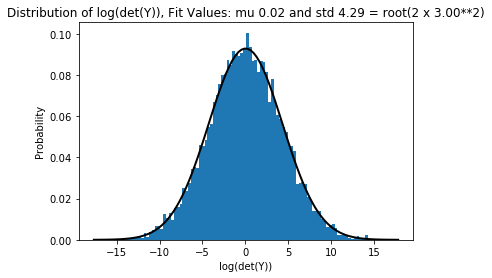

In [14]:
sigma = 3

R_4 = rejection_sampling(10000, 3)

H =[]
for k in range(10000):
    r = R_4[k]
    H.append(np.log(np.prod(np.exp(r))))


plt.hist(H, bins=100, normed=True)

xmin, xmax = plt.xlim()
print(xmin, xmax)
x = np.linspace(xmin, xmax, 100)
mu, std = norm.fit(np.array(H))
pdf = norm.pdf(x, mu, std)
plt.plot(x, pdf, 'k', linewidth=2)
plt.xlabel('log(det(Y))')
plt.ylabel('Probability')

title = "Distribution of log(det(Y)), Fit Values: mu {:.2f} and std {:.2f} = root(2 x {:.2f}**2)".format(mu, std, sigma)
plt.title(title)
plt.show()

The proposition is verified by our rejection sampling algorithm (try yourself by changing sigma and n_samples values)